In [29]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import cv2
import PIL
import einops
import os

HEIGHT = 112
WIDTH = 112

In [30]:
def load_most_moving_frames_center_crop(folder_path, num_frames=30, frame_size=(HEIGHT, WIDTH)):
    videos_array = []
    video_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]

    for filename in sorted(video_files):
        video_path = os.path.join(folder_path, filename)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            continue

        color_frames_processed = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            h, w, _ = frame.shape
            cropped_frame = None

            if w > h: # Landscape
                min_dim = h
                start_col = (w - h) // 2
                cropped_frame = frame[:, start_col:start_col + min_dim]
            elif h > w: # Portrait
                min_dim = w
                start_row = (h - w) // 2
                cropped_frame = frame[start_row:start_row + min_dim, :]
            else: # Already square
                cropped_frame = frame

            # Ridimensiona il frame ritagliato (che è quadrato) alla dimensione finale
            if cropped_frame is not None:
                 resized_frame = cv2.resize(cropped_frame, frame_size, interpolation=cv2.INTER_AREA)
                 color_frames_processed.append(resized_frame)

        cap.release()

        if not color_frames_processed:
             continue

        total_frames = len(color_frames_processed)
        diffs = []
        selected_frames = []

        if total_frames > 1:
            for j in range(1, total_frames):
                frame1 = color_frames_processed[j-1].astype(np.float32)
                frame2 = color_frames_processed[j].astype(np.float32)
                diff = np.sum(np.abs(frame2 - frame1))
                diffs.append((diff, j))

            diffs.sort(key=lambda x: x[0], reverse=True)
            best_indices = sorted([idx for (_, idx) in diffs[:min(num_frames, len(diffs))]])

            if len(best_indices) < num_frames and 0 not in best_indices:
                 if total_frames > 0:
                    best_indices.insert(0, 0)

            selected_frames = [color_frames_processed[k] for k in best_indices]

        elif total_frames == 1:
             selected_frames = [color_frames_processed[0]]
        else:
             continue

        if selected_frames:
            while len(selected_frames) < num_frames:
                selected_frames.append(selected_frames[-1].copy())
        else:
            black_frame = np.zeros((frame_size[0], frame_size[1], 3), dtype=np.uint8)
            selected_frames = [black_frame] * num_frames

        videos_array.append(selected_frames)

    return np.array(videos_array)

In [31]:
dirs = pathlib.Path("./dataset/my_test_categorized")
video_list = []
category = 0
y_mine = []

for dir_name in dirs.iterdir():
    print(dir_name)
    videos = load_most_moving_frames_center_crop(dir_name)
    video_list.append(videos)

    n_videos = videos.shape[0]
    y_mine += n_videos*[category]
    category += 1
    
X_mine = np.concatenate(video_list, axis=0)
X_mine.shape

dataset\my_test_categorized\0 - Left_Swipe
dataset\my_test_categorized\1 - Right_Swipe
dataset\my_test_categorized\2 - Stop
dataset\my_test_categorized\3 - Thumbs_Down
dataset\my_test_categorized\4 - Thumbs_Up


(25, 30, 112, 112, 3)

In [32]:
y_mine

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]

In [40]:
import numpy as np

def augment_brightness_video_consistent(video_data, brightness_delta_range=(-30, 30)):
    """
    Applica un aggiustamento della luminosità casuale ma consistente
    a tutti i fotogrammi di ciascun video nell'array.

    Args:
        video_data (np.array): L'array NumPy di input con shape
                               (num_videos, num_frames, H, W, 3) e dtype uint8.
        brightness_delta_range (tuple): L'intervallo (min, max) da cui estrarre
                                       il valore casuale da *aggiungere* ai pixel.

    Returns:
        np.array: Un nuovo array NumPy con la stessa shape dell'input,
                  con la luminosità modificata. dtype uint8.
    """
    # Crea una copia per non modificare l'array originale
    augmented_data = np.copy(video_data)
    num_videos = video_data.shape[0]

    for i in range(num_videos):
        # Genera UN solo valore casuale di luminosità per questo video
        brightness_adjust = np.random.randint(brightness_delta_range[0],
                                              brightness_delta_range[1] + 1)

        # Seleziona tutti i frame per il video corrente
        current_video_frames = augmented_data[i]

        # Applica l'aggiustamento in modo sicuro (evitando overflow/underflow)
        # Converti temporaneamente a un tipo di dato più grande
        frames_temp = current_video_frames.astype(np.int16)
        frames_temp += brightness_adjust

        # Assicura che i valori rimangano nell'intervallo valido per uint8 [0, 255]
        frames_clipped = np.clip(frames_temp, 0, 255)

        # Riconverti al tipo originale e assegna all'array di output
        augmented_data[i] = frames_clipped.astype(np.uint8)

    return augmented_data

# --- Esempio di utilizzo ---
# Assumendo che 'video_array_cropped' sia l'output della funzione precedente
# video_array_augmented_brightness = augment_brightness_video_consistent(video_array_cropped)

# Ora 'video_array_augmented_brightness' ha la stessa shape di
# 'video_array_cropped', ma con la luminosità modificata in modo
# temporalmente coerente per ciascun video.

In [41]:
video_array = augment_brightness_video_consistent(video_array)

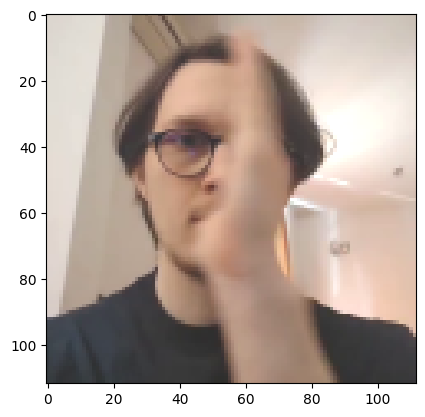

In [42]:
plt.imshow(cv2.cvtColor(video_array[4][10], cv2.COLOR_BGR2RGB))

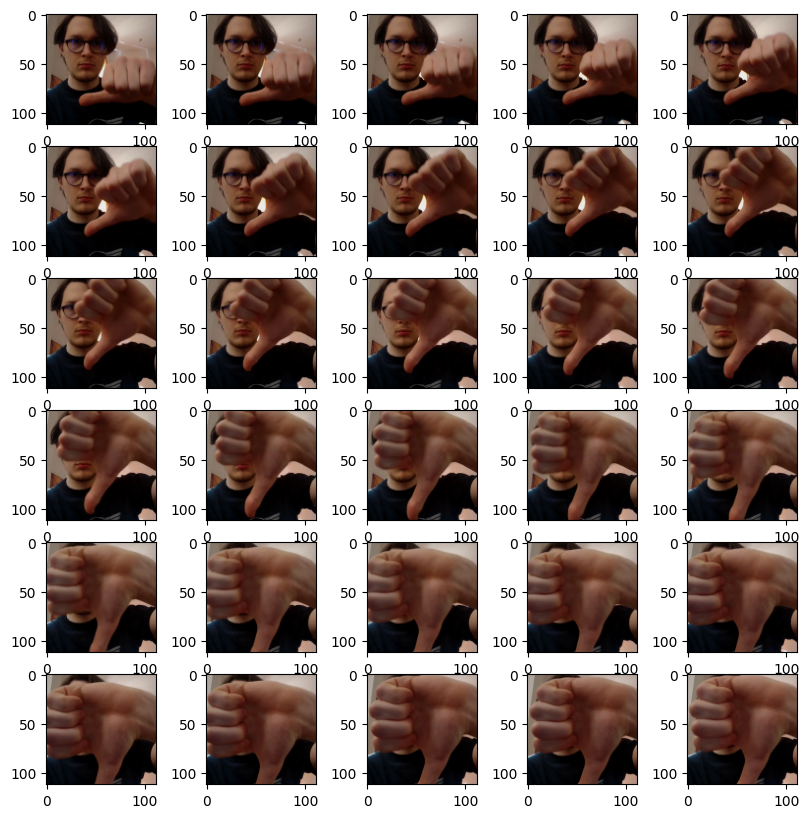

In [45]:
video_number = 18

fig, axs = plt.subplots(6, 5, figsize=(10,10))

for ax, frame in zip(axs.ravel(), range(30)):
    ax.imshow(cv2.cvtColor(video_array[video_number][frame], cv2.COLOR_BGR2RGB))

In [36]:
video_array.shape
len(video_array)

25

In [37]:
from sklearn.model_selection import train_test_split

X_train_mine, X_test_mine, y_train_mine, y_test_mine = train_test_split(X_mine, y_mine, test_size=0.2)

In [ ]:
input_shape = (None, 30, HEIGHT, WIDTH, 3)
inputs = layers.Input(shape=(input_shape[1:]))
x = inputs

# -------------------- data augemntation ------
#x = video_augmentation_layer()(input)
# --------------------

# -------------------- data augmentation ------
# Applica il layer personalizzato SOLO durante l'addestramento
#x = TemporallyConsistentBrightness(brightness_delta_range=(-30.0, 30.0))(x)
# --------------------

x = Conv2Plus1D(filters=16, kernel_size=(3, 5, 5), padding='same')(x) # originale era (3, 7, 7)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
#x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x) # scommentare in caso

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(5)(x) # aggiunta softmax finale
#x = layers.Dense(5, activation='softmax')(x) # aggiunta softmax finale

model = keras.Model(inputs, x)

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos